- 深くEDAする前に考えた仮説・影響を与えそうな変数例
  - 選手の大学名、ID、ジャージネームは影響しない→正しい。精度が向上した
  - 勝っているかどうかは影響を与える→不明、検討中

In [1]:
import os
import pandas as pd
from kaggle.competitions import nflrush
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import KFold
import lightgbm as lgb
import gc
import pickle
import tqdm
import category_encoders
pd.set_option("display.max_columns",1000)

## train data
The shape of train data is 509762 × 49.But, since one set consists of 22 lines, the actual number of data is 23171.
I converted it to a format that is easy to use.

In [2]:
env = nflrush.make_env()

In [3]:
train_df = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2020/train.csv', low_memory=False)

In [4]:
train_df.head(15)

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,496723,Eric Berry,29,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,212,12/29/1988,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,2495116,Allen Bailey,97,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,288,03/25/1989,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,2495493,Justin Houston,50,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,270,01/21/1989,Georgia,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,2506353,Derrick Johnson,56,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,245,11/22/1982,Texas,ILB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,2530794,Ron Parker,38,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,206,08/17/1987,Newberry,FS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
5,2017090700,20170907000118,away,75.06,24.00,1.01,0.32,0.18,308.34,95.01,2543494,Dee Ford,55,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-2,252,03/19/1991,Auburn,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
6,2017090700,20170907000118,away,74.11,16.64,1.11,0.83,0.02,357.23,322.59,2543637,Terrance Mitchell,39,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,5-11,190,05/17/1992,Oregon,CB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
7,2017090700,20170907000118,away,73.37,18.73,1.24,0.74,0.13,328.52,270.04,2543851,Phillip Gaines,23,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,193,04/04/1991,Rice,CB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
8,2017090700,20170907000118,away,56.63,26.90,0.26,1.86,0.28,344.70,55.31,2550257,Daniel Sorensen,49,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-2,208,03/05/1990,Brigham Young,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
9,2017090700,20170907000118,away,73.35,38.83,4.55,0.76,0.51,75.47,190.84,2552488,Marcus Peters,22,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB

In [5]:
unused_columns = ["GameId","PlayId","Team","Yards","TimeHandoff","TimeSnap"]

In [6]:
unique_columns = []
for c in train_df.columns:
    if c not in unused_columns+["PlayerBirthDate"] and len(set(train_df[c][:11]))!= 1 and c not in ["NflId", "DisplayName", "JerseyNumber", "PlayerCollegeName"]:
        unique_columns.append(c)
        print(c," is unique")
unique_columns+=["IsRusher"]
print(unique_columns)

X  is unique
Y  is unique
S  is unique
A  is unique
Dis  is unique
Orientation  is unique
Dir  is unique
PlayerHeight  is unique
PlayerWeight  is unique
Position  is unique
['X', 'Y', 'S', 'A', 'Dis', 'Orientation', 'Dir', 'PlayerHeight', 'PlayerWeight', 'Position', 'IsRusher']


In [7]:
ok = True
for i in range(0,509762,22):
    p=train_df["PlayId"][i]
    for j in range(1,22):
        if(p!=train_df["PlayId"][i+j]):
            ok=False
            break
print("train data is sorted by PlayId." if ok else "train data is not sorted by PlayId.")
ok = True
for i in range(0,509762,11):
    p=train_df["Team"][i]
    for j in range(1,11):
        if(p!=train_df["Team"][i+j]):
            ok=False
            break
print("train data is sorted by Team." if ok else "train data is not sorted by Team.")

train data is sorted by PlayId.
train data is sorted by Team.


In [8]:
# data cleaning 
map_abbr = {'ARI': 'ARZ', 'BAL': 'BLT', 'CLE': 'CLV', 'HOU': 'HST'}
for abb in train_df['PossessionTeam'].unique():
    map_abbr[abb] = abb
train_df['PossessionTeam'] = train_df['PossessionTeam'].map(map_abbr)
train_df['HomeTeamAbbr'] = train_df['HomeTeamAbbr'].map(map_abbr)
train_df['VisitorTeamAbbr'] = train_df['VisitorTeamAbbr'].map(map_abbr)

# offense formation
train_df["OffenseFormation"] = train_df["OffenseFormation"].fillna("Unknown") 

# Stadium
train_df["Stadium"] = train_df["Stadium"].map(lambda x: "Broncos Stadium at Mile High" if x=="Broncos Stadium At Mile High" 
                                             else ("CenturyLink Field" if x == "CenturyField" or x == x=="CenturyLink"
                                             else ("Everbank Field" if x == "EverBank Field"
                                             else ("FirstEnergy Stadium" if x =="First Energy Stadium" or x=="FirstEnergy" or x == "FirstEnergyStadium"
                                             else ("Lambeau Field" if x == "Lambeau field"
                                             else ("Los Angeles Memorial Coliseum" if x == "Los Angeles Memorial Coliesum"
                                             else ("M&T Bank Stadium" if x == "M & T Bank Stadium" or x == "M&T Stadium"
                                             else ("Mercedes-Benz Superdome" if x == "Mercedes-Benz Dome"
                                             else ("MetLife Stadium" if x == "MetLife" or x == "Metlife Stadium"
                                             else ("NRG Stadium" if x == "NRG"
                                             else ("Oakland-Alameda County Coliseum" if x == "Oakland Alameda-County Coliseum"
                                             else ("Paul Brown Stadium" if x == "Paul Brown Stdium"
                                             else ("Twickenham Stadium" if x == "Twickenham" else x)))))))))))))

# Location
train_df["Location"] = train_df["Location"].map(lambda x: "Arlington, TX" if x == "Arlington, Texas"
                        else ("Baltimore, MD" if x == "Baltimore, Maryland" or x == "Baltimore, Md."
                        else ("Charlotte, NC" if x == "Charlotte, North Carolina"
                        else ("Chicago, IL" if x == "Chicago. IL"
                        else ("Cincinnati, OH" if x == "Cincinnati, Ohio"
                        else ("Cleveland, OH" if x == "Cleveland" or x == "Cleveland Ohio" or x == "Cleveland, Ohio" or x == "Cleveland,Ohio"
                        else ("Detroit, MI" if x == "Detroit"
                        else ("East Rutherford, NJ" if x == "E. Rutherford, NJ" or x == "East Rutherford, N.J."
                        else ("Foxborough, MA" if x == "Foxborough, Ma"
                        else ("Houston, TX" if x == "Houston, Texas"
                        else ("Jacksonville, FL" if x == "Jacksonville Florida" or x == "Jacksonville, Fl" or x == "Jacksonville, Florida"
                        else ("London" if x == "London, England"
                        else ("Los Angeles, CA" if x == "Los Angeles, Calif."
                        else ("Miami Gardens, FLA" if x == "Miami Gardens, Fla."
                        else ("New Orleans, LA" if x == "New Orleans" or x == "New Orleans, La."
                        else ("Orchard Park, NY" if x == "Orchard Park NY"
                        else ("Philadelphia, PA" if x == "Philadelphia, Pa."
                        else ("Pittsburgh, PA" if x == "Pittsburgh"
                        else ("Seattle, WA" if x == "Seattle" else x)))))))))))))))))))

# Turf
train_df["Turf"] = train_df["Turf"].map(lambda x: "Artificial" if x == "Artifical"
                                       else ("Field Turf" if x == "FieldTurf" or x == "Field turf"
                                       else ("FieldTurf 360" if x == "FieldTurf360"
                                       else ("Natural Grass" if x == "natural grass" or x == "Naturall Grass" or x == "Natural grass" or x == "Natural"
                                       else ("Grass" if x == "grass"
                                       else ("UBU Speed Series-S5-M" if x == "UBU Sports Speed S5-M" else x))))))

# create new features
train_df['DefendersInTheBox_vs_Distance'] = train_df['DefendersInTheBox'] / train_df['Distance']
train_df['IsRusher'] = train_df['NflId'] == train_df['NflIdRusher']
train_df["IfPossess"] = train_df["FieldPosition"] == train_df["PossessionTeam"]

In [9]:
all_columns = []
for c in train_df.columns:
    if c not in unique_columns + unused_columns+["DefensePersonnel","GameClock","PlayerBirthDate", "NflId", "NflIdRusher", "DisplayName", "JerseyNumber"]:
        all_columns.append(c)
all_columns.append("DL")
all_columns.append("LB")    
all_columns.append("DB")
all_columns.append("GameHour")   
for c in unique_columns:
    for i in range(22):
        all_columns.append(c+str(i))

In [10]:
# preprocessing of each variable
def strtoseconds(txt):
    txt = txt.split(':')
    ans = int(txt[0])*60 + int(txt[1]) + int(txt[2])/60
    return ans

def str_to_float(txt):
    try:
        return float(txt)
    except:
        return -1

lbl_dict = {}
for c in train_df.columns:
    if c == "DefensePersonnel":
        arr = [[int(s[0]) for s in t.split(", ")] for t in train_df["DefensePersonnel"]]
        train_df["DL"] = np.array([a[0] for a in arr])
        train_df["LB"] = np.array([a[1] for a in arr])
        train_df["DB"] = np.array([a[2] for a in arr])
    elif c == "GameClock":
        arr = [[int(s) for s in t.split(":")] for t in train_df["GameClock"]]
        train_df["GameHour"] = pd.Series([a[0] for a in arr])
        train_df['TimeLeft'] = train_df['GameClock'].apply(strtoseconds)
    elif c == "PlayerBirthDate":
        arr = [[int(s) for s in t.split("/")] for t in train_df["PlayerBirthDate"]]
        train_df["BirthY"] = pd.Series([a[2] for a in arr])
    elif c == "PlayerHeight":
        train_df['PlayerHeight'] = train_df['PlayerHeight'].apply(lambda x: 12*int(x.split('-')[0])+int(x.split('-')[1]))
    #     arr = [float(s.split("-")[0]) * 30.48 + float(s.split("-")[1]) * 2.54
    #         for s in list(train_df["PlayerHeight"])]
    #     train_df["PlayerHeight"] = pd.Series(arr)
    elif c == "WindSpeed":
        train_df['WindSpeed'] = train_df['WindSpeed'].apply(lambda x: x.lower().replace('mph', '').strip() if not pd.isna(x) else x)
        train_df['WindSpeed'] = train_df['WindSpeed'].apply(lambda x: (int(x.split('-')[0])+int(x.split('-')[1]))/2 if not pd.isna(x) and '-' in x else x)
        train_df['WindSpeed'] = train_df['WindSpeed'].apply(lambda x: (int(x.split()[0])+int(x.split()[-1]))/2 if not pd.isna(x) and type(x)!=float and 'gusts up to' in x else x)
        train_df['WindSpeed'] = train_df['WindSpeed'].apply(str_to_float)
    elif train_df[c].dtype=='object' and c not in unused_columns: 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[c].values))
        lbl_dict[c] = lbl
        train_df[c] = lbl.transform(list(train_df[c].values))

In [11]:
train_data=np.zeros((509762//22,len(all_columns)))
for i in tqdm.tqdm(range(0,509762,22)):
    count=0
    for c in all_columns:
        if c in train_df:
            train_data[i//22][count] = train_df[c][i]
            count+=1
    for c in unique_columns:
        for j in range(22):
            train_data[i//22][count] = train_df[c][i+j]
            count+=1        

100%|██████████| 23171/23171 [02:56<00:00, 130.92it/s]


In [12]:
y_train_ = np.array([train_df["Yards"][i] for i in range(0,509762,22)])
X_train = pd.DataFrame(data=train_data,columns=all_columns)

In [13]:
X_train.head(3)

,Season,YardLine,Quarter,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,OffenseFormation,OffensePersonnel,DefendersInTheBox,PlayDirection,PlayerCollegeName,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection,DefendersInTheBox_vs_Distance,IfPossess,DL,LB,DB,GameHour,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,Y0,Y1,Y2,Y3,Y4,Y5,Y6,Y7,Y8,Y9,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17,Y18,Y19,Y20,Y21,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12,S13,S14,S15,S16,S17,S18,S19,S20,S21,A0,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16,A17,A18,A19,A20,A21,Dis0,Dis1,Dis2,Dis3,Dis4,Dis5,Dis6,Dis7,Dis8,Dis9,Dis10,Dis11,Dis12,Dis13,Dis14,Dis15,Dis16,Dis17,Dis18,Dis19,Dis20,Dis21,Orientation0,Orientation1,Orientation2,Orientation3,Orientation4,Orientation5,Orientation6,Orientation7,Orientation8,Orientation9,Orientation10,Orientation11,Orientation12,Orientation13,Orientation14,Orientation15,Orientation16,Orientation17,Orientation18,Orientation19,Orientation20,Orientation21,Dir0,Dir1,Dir2,Dir3,Dir4,Dir5,Dir6,Dir7,Dir8,Dir9,Dir10,Dir11,Dir12,Dir13,Dir14,Dir15,Dir16,Dir17,Dir18,Dir19,Dir20,Dir21,PlayerHeight0,PlayerHeight1,PlayerHeight2,PlayerHeight3,PlayerHeight4,PlayerHeight5,PlayerHeight6,PlayerHeight7,PlayerHeight8,PlayerHeight9,PlayerHeight10,PlayerHeight11,PlayerHeight12,PlayerHeight13,PlayerHeight14,PlayerHeight15,PlayerHeight16,PlayerHeight17,PlayerHeight18,PlayerHeight19,PlayerHeight20,PlayerHeight21,PlayerWeight0,PlayerWeight1,PlayerWeight2,PlayerWeight3,PlayerWeight4,PlayerWeight5,PlayerWeight6,PlayerWeight7,PlayerWeight8,PlayerWeight9,PlayerWeight10,PlayerWeight11,PlayerWeight12,PlayerWeight13,PlayerWeight14,PlayerWeight15,PlayerWeight16,PlayerWeight17,PlayerWeight18,PlayerWeight19,PlayerWeight20,PlayerWeight21,Position0,Position1,Position2,Position3,Position4,Position5,Position6,Position7,Position8,Position9,Position10,Position11,Position12,Position13,Position14,Position15,Position16,Position17,Position18,Position19,Position20,Position21,IsRusher0,IsRusher1,IsRusher2,IsRusher3,IsRusher4,IsRusher5,IsRusher6,IsRusher7,IsRusher8,IsRusher9,IsRusher10,IsRusher11,IsRusher12,IsRusher13,IsRusher14,IsRusher15,IsRusher16,IsRusher17,IsRusher18,IsRusher19,IsRusher20,IsRusher21
0,2017.0,35.0,1.0,20.0,3.0,2.0,20.0,0.0,0.0,5.0,9.0,6.0,0.0,246.0,20.0,15.0,1.0,10.0,11.0,18.0,3.0,7.0,63.0,77.0,8.0,36.0,3.0,1.0,2.0,3.0,6.0,14.0,73.91,74.67,74.00,71.46,69.32,75.06,74.11,73.37,56.63,73.35,74.15,75.82,74.78,75.43,75.90,79.76,76.47,74.70,78.75,74.60,74.58,74.58,34.84,32.64,33.20,27.70,35.42,24.00,16.64,18.73,26.90,38.83,28.90,17.56,33.21,32.41,25.12,29.49,36.91,19.19,30.53,31.88,29.12,28.47,1.69,0.42,1.22,0.42,1.82,1.01,1.11,1.24,0.26,4.55,0.72,2.30,1.71,1.50,1.38,0.84,5.15,2.10,3.63,1.86,1.00,1.70,1.13,1.35,0.59,0.54,2.43,0.32,0.83,0.74,1.86,0.76,0.73,1.39,0.82,1.36,0.80,1.22,0.77,1.48,3.35,1.51,0.69,1.55,0.40,0.01,0.31,0.02,0.16,0.18,0.02,0.13,0.28,0.51,0.01,0.55,0.19,0.32,0.19,0.0,0.59,0.51,0.38,0.17,0.22,0.24,81.99,27.61,3.01,359.77,12.63,308.34,357.23,328.52,344.70,75.47,342.58,178.97,178.82,207.08,133.01,192.18,112.02,152.14,161.98,218.49,169.36,207.09,177.18,198.70,202.73,105.64,164.31,95.01,322.59,270.04,55.31,190.84,274.14,284.15,215.90,222.76,198.55,110.86,195.09,278.52,245.74,267.32,242.05,255.67,72.0,75.0,75.0,75.0,72.0,74.0,71.0,72.0,74.0,72.0,78.0,71.0,78.0,78.0,81.0,76.0,73.0,70.0,70.0,73.0,75.0,77.0,212.0,288.0,270.0,245.0,206.0,252.0,190.0,193.0,208.0,197.0,308.0,185.0,265.0,335.0,325.0,225.0,210.0,183.0,205.0,310.0,300.0,308.0,21.0,3.0,3.0,10.0,7.0,3.0,1.0,1.0,21.0,1.0,5.0,24.0,23.0,22.0,22.0,17.0,24.0,24.0,18.0,8.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2017.0,43.0,1.0,20.0,1.0,10.0,20.0,0.0,0.0,5.0,9.0,6.0,0.0,246.0,20.0,15.0,1.0,10.0,11.0,18.0,3.0,7.0,63.0,77.0,8.0,36.0,0.6,1.0,2.0,3.0,6.0,13.0,65.73,66.04,66.02,63.31,60.51,66.60,65.12,65.18

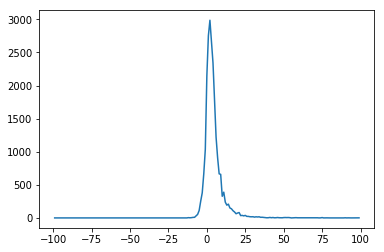

In [14]:
data = [0 for i in range(199)]
for y in y_train_:
    data[int(y+99)]+=1
plt.plot([i-99 for i in range(199)],data)

Since the variance is small, I standardized the objective variable.

In [15]:
# scaler = preprocessing.StandardScaler()
# scaler.fit([[y] for y in y_train_])
# y_train = np.array([y[0] for y in scaler.transform([[y] for y in y_train_])])
scaler = preprocessing.StandardScaler()
scaler.fit(y_train_.reshape(-1, 1))
y_train = scaler.transform(y_train_.reshape(-1, 1)).flatten()

## train
I used LGBMRegressor.
I wanted to use multi-class classification, but the number of datasets was small and it was difficult to split them including all labels.

In [16]:
folds = 10
seed = 222
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_valid_pred = np.zeros(X_train.shape[0])
models = []

for tr_idx, val_idx in kf.split(X_train, y_train):
    tr_x, tr_y = X_train.iloc[tr_idx,:], y_train[tr_idx]
    vl_x, vl_y = X_train.iloc[val_idx,:], y_train[val_idx]
            
    print(len(tr_x),len(vl_x))
    tr_data = lgb.Dataset(tr_x, label=tr_y)
    vl_data = lgb.Dataset(vl_x, label=vl_y)  
    clf = lgb.LGBMRegressor(n_estimators=200,learning_rate=0.01)
    clf.fit(tr_x, tr_y,
        eval_set=[(vl_x, vl_y)],
        early_stopping_rounds=20,
        verbose=False)
    y_valid_pred[val_idx] += clf.predict(vl_x, num_iteration=clf.best_iteration_)
    models.append(clf)

gc.collect()

20853 2318
20854 2317
20854 2317
20854 2317
20854 2317
20854 2317
20854 2317
20854 2317
20854 2317
20854 2317


243

## evaluation

In [17]:
y_pred = np.zeros((509762//22,199))
y_ans = np.zeros((509762//22,199))

for i,p in enumerate(np.round(scaler.inverse_transform(y_valid_pred))):
    p+=99
    for j in range(199):
        if j>=p+10:
            y_pred[i][j]=1.0
        elif j>=p-10:
            y_pred[i][j]=(j+10-p)*0.05

for i,p in enumerate(scaler.inverse_transform(y_train)):
    p+=99
    for j in range(199):
        if j>=p:
            y_ans[i][j]=1.0

print("validation score:",np.sum(np.power(y_pred-y_ans,2))/(199*(509762//22)))

validation score: 0.015563190992726374


## make submission

When there is a label that does not exist in the training data, it is handled as nan.
If you can check the error one by one and complement it, you will get better score.

In [18]:
index = 0
for (test_df, sample_prediction_df) in tqdm.tqdm(env.iter_test()):
    map_abbr = {'ARI': 'ARZ', 'BAL': 'BLT', 'CLE': 'CLV', 'HOU': 'HST'}
    for abb in test_df['PossessionTeam'].unique():
        map_abbr[abb] = abb
    test_df['PossessionTeam'] = test_df['PossessionTeam'].map(map_abbr)
    test_df['HomeTeamAbbr'] = test_df['HomeTeamAbbr'].map(map_abbr)
    test_df['VisitorTeamAbbr'] = test_df['VisitorTeamAbbr'].map(map_abbr)  
    
    # offense formation
    test_df["OffenseFormation"] = train_df["OffenseFormation"].fillna("Unknown") 

    # Stadium
    test_df["Stadium"] = test_df["Stadium"].map(lambda x: "Broncos Stadium at Mile High" if x=="Broncos Stadium At Mile High" 
                                             else ("CenturyLink Field" if x == "CenturyField" or x == x=="CenturyLink"
                                             else ("Everbank Field" if x == "EverBank Field"
                                             else ("FirstEnergy Stadium" if x =="First Energy Stadium" or x=="FirstEnergy" or x == "FirstEnergyStadium"
                                             else ("Lambeau Field" if x == "Lambeau field"
                                             else ("Los Angeles Memorial Coliseum" if x == "Los Angeles Memorial Coliesum"
                                             else ("M&T Bank Stadium" if x == "M & T Bank Stadium" or x == "M&T Stadium"
                                             else ("Mercedes-Benz Superdome" if x == "Mercedes-Benz Dome"
                                             else ("MetLife Stadium" if x == "MetLife" or x == "Metlife Stadium"
                                             else ("NRG Stadium" if x == "NRG"
                                             else ("Oakland-Alameda County Coliseum" if x == "Oakland Alameda-County Coliseum"
                                             else ("Paul Brown Stadium" if x == "Paul Brown Stdium"
                                             else ("Twickenham Stadium" if x == "Twickenham" else x)))))))))))))
    
    test_df["Location"] = test_df["Location"].map(lambda x: "Arlington, TX" if x == "Arlington, Texas"
                        else ("Baltimore, MD" if x == "Baltimore, Maryland" or x == "Baltimore, Md."
                        else ("Charlotte, NC" if x == "Charlotte, North Carolina"
                        else ("Chicago, IL" if x == "Chicago. IL"
                        else ("Cincinnati, OH" if x == "Cincinnati, Ohio"
                        else ("Cleveland, OH" if x == "Cleveland" or x == "Cleveland Ohio" or x == "Cleveland, Ohio" or x == "Cleveland,Ohio"
                        else ("Detroit, MI" if x == "Detroit"
                        else ("East Rutherford, NJ" if x == "E. Rutherford, NJ" or x == "East Rutherford, N.J."
                        else ("Foxborough, MA" if x == "Foxborough, Ma"
                        else ("Houston, TX" if x == "Houston, Texas"
                        else ("Jacksonville, FL" if x == "Jacksonville Florida" or x == "Jacksonville, Fl" or x == "Jacksonville, Florida"
                        else ("London" if x == "London, England"
                        else ("Los Angeles, CA" if x == "Los Angeles, Calif."
                        else ("Miami Gardens, FLA" if x == "Miami Gardens, Fla."
                        else ("New Orleans, LA" if x == "New Orleans" or x == "New Orleans, La."
                        else ("Orchard Park, NY" if x == "Orchard Park NY"
                        else ("Philadelphia, PA" if x == "Philadelphia, Pa."
                        else ("Pittsburgh, PA" if x == "Pittsburgh"
                        else ("Seattle, WA" if x == "Seattle" else x)))))))))))))))))))
    
    test_df["Turf"] = test_df["Turf"].map(lambda x: "Artificial" if x == "Artifical"
                                       else ("Field Turf" if x == "FieldTurf" or x == "Field turf"
                                       else ("FieldTurf 360" if x == "FieldTurf360"
                                       else ("Natural Grass" if x == "natural grass" or x == "Naturall Grass" or x == "Natural grass" or x == "Natural"
                                       else ("Grass" if x == "grass"
                                       else ("UBU Speed Series-S5-M" if x == "UBU Sports Speed S5-M" else x))))))
    
    test_df['DefendersInTheBox_vs_Distance'] = test_df['DefendersInTheBox'] / test_df['Distance']
    test_df['IsRusher'] = test_df['NflId'] == test_df['NflIdRusher']
    test_df["IfPossess"] = test_df["FieldPosition"] == test_df["PossessionTeam"]
    
    for c in test_df.columns:
        if c == "DefensePersonnel":
            try:
                arr = [[int(s[0]) for s in t.split(", ")] for t in test_df["DefensePersonnel"]]
                test_df["DL"] = [a[0] for a in arr]
                test_df["LB"] = [a[1] for a in arr]
                test_df["DB"] = [a[2] for a in arr]
            except:
                test_df["DL"] = [np.nan for i in range(22)]
                test_df["LB"] = [np.nan for i in range(22)]
                test_df["DB"] = [np.nan for i in range(22)]
        elif c == "GameClock":
            try:
                arr = [[int(s) for s in t.split(":")] for t in test_df["GameClock"]]
                test_df["GameHour"] = pd.Series([a[0] for a in arr])
                test_df['TimeLeft'] = test_df['GameClock'].apply(strtoseconds)
            except:
                test_df["GameHour"] = [np.nan for i in range(22)]
                test_df["TimeLeft"] = [np.nan for i in range(22)]
        elif c == "PlayerBirthDate":
            try:
                arr = [[int(s) for s in t.split("/")] for t in test_df["PlayerBirthDate"]]
                test_df["BirthY"] = pd.Series([a[2] for a in arr])
            except:
                test_df["BirthY"] = [np.nan for i in range(22)]
        elif c == "PlayerHeight":
            test_df['PlayerHeight'] = test_df['PlayerHeight'].apply(lambda x: 12*int(x.split('-')[0])+int(x.split('-')[1]))
        #     try:
        #         arr = [float(s.split("-")[0]) * 30.48 + float(s.split("-")[1]) * 2.54
        #             for s in list(test_df["PlayerHeight"])]
        #         test_df["PlayerHeight"] = pd.Series(arr)
        #     except:
        #         test_df["PlayerHeight"] = [np.nan for i in range(22)]
        elif c == "WindSpeed":
            test_df['WindSpeed'] = test_df['WindSpeed'].apply(lambda x: x.lower().replace('mph', '').strip() if not pd.isna(x) else x)
            test_df['WindSpeed'] = test_df['WindSpeed'].apply(lambda x: (int(x.split('-')[0])+int(x.split('-')[1]))/2 if not pd.isna(x) and '-' in x else x)
            test_df['WindSpeed'] = test_df['WindSpeed'].apply(lambda x: (int(x.split()[0])+int(x.split()[-1]))/2 if not pd.isna(x) and type(x)!=float and 'gusts up to' in x else x)
            test_df['WindSpeed'] = test_df['WindSpeed'].apply(str_to_float)
        elif c in lbl_dict and test_df[c].dtype=='object'and c not in unused_columns\
            and not pd.isnull(test_df[c]).any():
            try:
                test_df[c] = lbl_dict[c].transform(list(test_df[c].values))
            except:
                test_df[c] = [np.nan for i in range(22)]          
                
    count=0
    test_data = np.zeros((1,len(all_columns)))

    for c in all_columns:
        if c in test_df:
            try:
                test_data[0][count] = test_df[c][index]
            except:
                test_data[0][count] = np.nan
            count+=1
    for c in unique_columns:
        for j in range(22):
            try:
                test_data[0][count] = test_df[c][index + j]
            except:
                test_data[0][count] = np.nan
            count+=1        
    y_pred = np.zeros(199)        
    y_pred_p = np.sum(np.round(scaler.inverse_transform(
        [model.predict(test_data)[0] for model in models])))/folds
    y_pred_p += 99
    for j in range(199):
        if j>=y_pred_p+10:
            y_pred[j]=1.0
        elif j>=y_pred_p-10:
            y_pred[j]=(j+10-y_pred_p)*0.05
    env.predict(pd.DataFrame(data=[y_pred],columns=sample_prediction_df.columns))
    index += 22
env.write_submission_file()

3438it [04:27, 12.86it/s]


Your submission file has been saved!  Once you `Commit` your Notebook and it finishes running, you can submit the file to the competition from the Notebook Viewer `Output` tab.


The organizers seemed to expect to predict one by one, so I did. However, it seems that it is likely to be faster to predict at once after all the evaluation data is acquired by dummy input.This model is a simple one that has not been tuned, so I think we can still expect a better score.